# Ensemble Simulation

An ensemble simulation is a set of simulations, indiviudal referred to as "members", which vary in any way.

From `help(wrfhydropy.CycleSimulation)`:
```
Class for a WRF-Hydro EnsembleSimulation object. The Ensemble Simulation object is used to
orchestrate a set of 'N' WRF-Hydro simulations. It requires members with pre-compiled models
and there are set and get methods across the ensemble (member_diffs & set_member_diffs). Jobs
and scheduler set on the EnsembleSimulation object are set on all the members. 
```

;; last line means that all ensemble members execute at the same time

We keep the verbiage to a minimum in this example. Please refer to the first example for gory details.

## Preliminary

In [1]:
import copy
import datetime
import os
import pandas as pd
import pathlib
import pickle
from pprint import pprint
import shlex
import subprocess
import sys
import wrfhydropy

/glade/work/jamesmcc/python_envs/368_/lib/python3.6/site-packages/dask/config.py:131: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


## User Configuration
This section should be all you need to tailor to your own machine.

In [2]:
model_repo = pathlib.Path('/glade/u/home/jamesmcc/WRF_Hydro/wrf_hydro_nwm_public')
experiment_dir = pathlib.Path('/glade/scratch/jamesmcc/wrfhydropy_ensemble_example')
if not experiment_dir.exists():
    os.mkdir(str(experiment_dir))
os.chdir(str(experiment_dir))

## Simulation Object
First, we build the simulation that serves as the basis for the members of ensemble.  

The domain is pulled from the cloud, just as in the first (end-to-end) example. (Note that this section will not run on a cheyenne compute node as they are not connected to the internet.)

In [3]:
domain_dir = experiment_dir / 'domain'
if not domain_dir.exists(): 
    sys.path.append(str(model_repo / 'tests/local/utils'))
    from gdrive_download import download_file_from_google_drive
    file_id = '1xFYB--zm9f8bFHESzgP5X5i7sZryQzJe'
    file_target = 'gdrive_testcase.tar.gz'
    download_file_from_google_drive(
        file_id, 
        str(experiment_dir.joinpath(file_target)))
    untar_cmd = 'tar -xf ' + file_target + '; mv example_case domain'
    subprocess.run(
        untar_cmd, 
        shell=True,
        cwd=str(experiment_dir))

In [4]:
hrldas_model_side_file = model_repo / 'trunk/NDHMS/hrldas_namelists.json'
hrldas_domain_side_file = domain_dir / 'hrldas_namelist_patches.json'
hydro_model_side_file = model_repo / 'trunk/NDHMS/hydro_namelists.json'
hydro_domain_side_file = domain_dir / 'hydro_namelist_patches.json'
compile_options_file = model_repo / 'trunk/NDHMS/compile_options.json'
config = 'nwm_ana'

In [5]:
domain = wrfhydropy.Domain(
    domain_top_dir=domain_dir,
    domain_config=config)

In [6]:
model = wrfhydropy.Model(
    model_repo / 'trunk/NDHMS',
    compiler='ifort',
    compile_options={'WRF_HYDRO_NUDGING': 0},  # Turn off nudging for this ensemble experiment
    model_config=config)

In [7]:
compile_dir = experiment_dir / 'compile'
if not compile_dir.exists():
    model.compile(compile_dir)
else: 
    model = pickle.load(compile_dir.joinpath('WrfHydroModel.pkl').open('rb'))

In [8]:
simulation = wrfhydropy.Simulation()
simulation.add(model)
simulation.add(domain)

Note that we dont need to compose or run the Simulation. 

## EnsembleSimulation Object
The documentation is always a work in progress! Please provide feedback on how to continue to improve it.

In [9]:
help(wrfhydropy.EnsembleSimulation)

Help on class EnsembleSimulation in module wrfhydropy.core.ensemble:

class EnsembleSimulation(builtins.object)
 |  Class for a WRF-Hydro EnsembleSimulation object. The Ensemble Simulation object is used to
 |  orchestrate a set of 'N' WRF-Hydro simulations. It requires members with pre-compiled models
 |  and there are set and get methods across the ensemble (member_diffs & set_member_diffs). Jobs
 |  and scheduler set on the EnsembleSimulation object are set on all the members.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, ncores:int=1)
 |      Instantiates an EnsembleSimulation object.
 |  
 |  __len__(self)
 |  
 |  add(self, obj:Union[list, wrfhydropy.core.schedulers.Scheduler, wrfhydropy.core.job.Job])
 |      Add an approparite object to an EnsembleSimulation, such as a Simulation, Job, or
 |      Scheduler.
 |      Args:
 |          obj: the object to add.
 |  
 |  collect(self, output=True)
 |  
 |  compose(self, symlink_domain:bool=True, force:bool=False, check_nlst_

Instantiate the CycleSimulation object with the required arguments.

In [10]:
ensemble = wrfhydropy.EnsembleSimulation()
ensemble.add(simulation)
ensemble.replicate_member(4)
len(ensemble)

4

In [11]:
pprint(ensemble.member_diffs)

{'number': ['000', '001', '002', '003'],
 'run_dir': ['member_000', 'member_001', 'member_002', 'member_003']}


We'll perturb 2 parameters to get for different members:  
  * dtrt_ch:  5, 20 minutes.   
  * Lakes: on, off 

In [12]:
dtrtch_att_tuple = ('base_hydro_namelist', 'hydro_nlist', 'dtrt_ch')
ensemble.set_member_diffs(dtrtch_att_tuple, [5*60, 20*60, 5*60, 20*60])

original_route_lake_f = simulation.base_hydro_namelist['hydro_nlist']['route_lake_f']
lakef_att_tuple = ('base_hydro_namelist', 'hydro_nlist', 'route_lake_f')
ensemble.set_member_diffs(lakef_att_tuple, [original_route_lake_f] * 2 + [''] * 2)
outlake_att_tuple = ('base_hydro_namelist', 'hydro_nlist', 'outlake')
ensemble.set_member_diffs(outlake_att_tuple, [1, 1, 0, 0])

In [13]:
pprint(ensemble.member_diffs)

{'number': ['000', '001', '002', '003'],
 'run_dir': ['member_000', 'member_001', 'member_002', 'member_003'],
 ('base_hydro_namelist', 'hydro_nlist', 'dtrt_ch'): [300, 1200, 300, 1200],
 ('base_hydro_namelist', 'hydro_nlist', 'outlake'): [1, 1, 0, 0],
 ('base_hydro_namelist', 'hydro_nlist', 'route_lake_f'): ['./NWM/DOMAIN/LAKEPARM.nc',
                                                          './NWM/DOMAIN/LAKEPARM.nc',
                                                          '',
                                                          '']}


Now we have a CycleSimulation to which we need to add our simulation (above) and a job.

In [14]:
model_start_time = datetime.datetime(2011, 8, 26, 0)
model_end_time = model_start_time + datetime.timedelta(hours=6)
exe_cmd = 'mpirun -np 1 ./wrf_hydro.exe'
job_ensemble = wrfhydropy.Job(
    job_id='ensemble',
    exe_cmd=exe_cmd,
    model_start_time=model_start_time,
    model_end_time=model_end_time,
    restart=True,
    restart_freq_hr=-99999,
    output_freq_hr=1)

ensemble.add(job_ensemble)
ensemble_copy = copy.deepcopy(ensemble)

If we consider the job "ready to go", we can compose it to disk. This compose step follows the same pattern as a Simulation. 

In [16]:
ensemble_dir = experiment_dir / 'ensemble'
os.mkdir(ensemble_dir)
os.chdir(ensemble_dir)
ensemble.compose()

Composing simulation into directory:'/glade/scratch/jamesmcc/wrfhydropy_ensemble_example/ensemble/member_000'
Getting domain files...
Making job directories...
Validating job input files
ensemble
Model already compiled, copying files...
Simulation successfully composed
Composing simulation into directory:'/glade/scratch/jamesmcc/wrfhydropy_ensemble_example/ensemble/member_001'
Getting domain files...
Making job directories...
Validating job input files
ensemble
Model already compiled, copying files...
Simulation successfully composed
Composing simulation into directory:'/glade/scratch/jamesmcc/wrfhydropy_ensemble_example/ensemble/member_002'
Getting domain files...
Making job directories...
Validating job input files
ensemble
Model already compiled, copying files...
Simulation successfully composed
Composing simulation into directory:'/glade/scratch/jamesmcc/wrfhydropy_ensemble_example/ensemble/member_003'
Getting domain files...
Making job directories...
Validating job input files
ens

As with Simulation objects, this time between compose (to disk) and run is a critical point for the user to look at the runs and verify that everything is configured correctly. 

Since these cycles are dependent on each other, we can not run them in parallel. We perform a serial, interactive run here. (Other run modes will be shown in subsequent examples).

In [17]:
ensemble.run()


Running job ensemble: 
    Wall start time: 2020-04-08 13:03:53
    Model start time: 2011-08-26 00:00
    Model end time: 2011-08-26 06:00

Running job ensemble: 
    Wall start time: 2020-04-08 13:03:56
    Model start time: 2011-08-26 00:00
    Model end time: 2011-08-26 06:00

Running job ensemble: 
    Wall start time: 2020-04-08 13:03:58
    Model start time: 2011-08-26 00:00
    Model end time: 2011-08-26 06:00

Running job ensemble: 
    Wall start time: 2020-04-08 13:04:01
    Model start time: 2011-08-26 00:00
    Model end time: 2011-08-26 06:00


0

## Ensemble Collection
I have not yet implemented a syntactic sugar version for more complicated objects than Simulations.... so we do this the "unchained" or "old fashioned" way. 

In [18]:
ens_chanobs_files = sorted(ensemble_dir.glob('*/*CHANOBS*'))
ens_chanobs_ds = wrfhydropy.open_whp_dataset(ens_chanobs_files)

n_files 24


Note that the `open_whp_dataset` function handles the dimensions of the cycle and that the time **dimensions** are `lead_time` and `reference_time` and `valid_time` is a variable with those dimensions. 

In [19]:
ens_chanobs_ds

<xarray.Dataset>
Dimensions:     (feature_id: 4, member: 4, time: 6)
Coordinates:
    latitude    (feature_id) float32 41.470795 41.473614 41.449814 41.40192
    longitude   (feature_id) float32 -73.76059 -73.69085 -73.73565 -73.68741
  * time        (time) datetime64[ns] 2011-08-26T01:00:00 ... 2011-08-26T06:00:00
  * feature_id  (feature_id) int32 6226948 6226964 6227008 6227150
  * member      (member) int64 0 1 2 3
Data variables:
    crs         (member, time) |S1 b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    order       (member, time, feature_id) int32 3 2 4 4 3 2 4 ... 2 4 4 3 2 4 4
    elevation   (member, time, feature_id) float32 180.48 183.15 ... 147.61
    streamflow  (member, time, feature_id) float32 0.43056196 ... 0.077781275
Attributes:
    featureType:        timeSeries
    proj4:              +proj=lcc +units=m +a=6370000.0 +b=6370000.0 +lat_1=3...
    station_dimension:  feature_id
    Conventions:        CF-1.6

Do the easiest plotting thing possible.

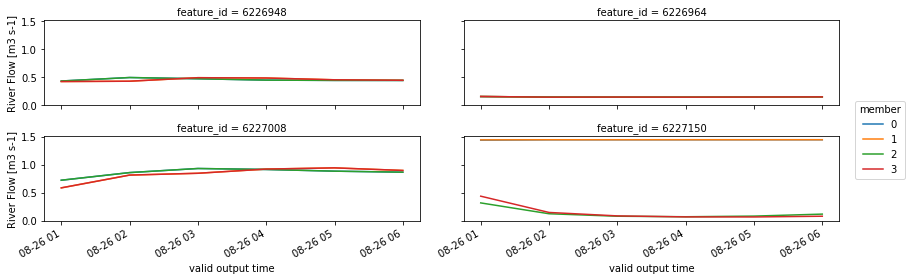

In [21]:
(ens_chanobs_ds.streamflow.plot
    .line(x='time', hue='member', col='feature_id',
          col_wrap=2,
          figsize=(12, 4)))

# Cycle Ensembles

In [32]:
init_times = [datetime.datetime(2011, 8, 26, 0) + 
              datetime.timedelta(hours=hh) for hh in range(0, 24, 6)]
init_times

[datetime.datetime(2011, 8, 26, 0, 0),
 datetime.datetime(2011, 8, 26, 6, 0),
 datetime.datetime(2011, 8, 26, 12, 0),
 datetime.datetime(2011, 8, 26, 18, 0)]

In [33]:
restart_dirs_cycle = ['.'] + ([-6] * (len(init_times)-1))
restart_dirs_ens_cycle = [[rr] * 4 for rr in restart_dirs_cycle]
restart_dirs_ens_cycle

[['.', '.', '.', '.'], [-6, -6, -6, -6], [-6, -6, -6, -6], [-6, -6, -6, -6]]

In [34]:
cycle_ens = wrfhydropy.CycleSimulation(
    init_times=init_times, restart_dirs=restart_dirs_ens_cycle)

In [35]:
cycle_ens.add(ensemble_copy)  ## if you add the original ensemble here, there will be a type error because it was composed to disk
cycle_ens.add(job_ensemble)

In [36]:
cycle_ensemble_dir = experiment_dir / 'cycle_ensemble'
os.mkdir(cycle_ensemble_dir)
os.chdir(cycle_ensemble_dir)
cycle_ens.compose()

Composing simulation into directory:'/glade/scratch/jamesmcc/wrfhydropy_ensemble_example/cycle_ensemble/cast_2011082600/member_000'
Getting domain files...
Making job directories...
Validating job input files
ensemble
Model already compiled, copying files...
Simulation successfully composed
Composing simulation into directory:'/glade/scratch/jamesmcc/wrfhydropy_ensemble_example/cycle_ensemble/cast_2011082600/member_001'
Getting domain files...
Making job directories...
Validating job input files
ensemble
Model already compiled, copying files...
Simulation successfully composed
Composing simulation into directory:'/glade/scratch/jamesmcc/wrfhydropy_ensemble_example/cycle_ensemble/cast_2011082600/member_002'
Getting domain files...
Making job directories...
Validating job input files
ensemble
Model already compiled, copying files...
Simulation successfully composed
Composing simulation into directory:'/glade/scratch/jamesmcc/wrfhydropy_ensemble_example/cycle_ensemble/cast_2011082600/memb

In [ ]:
# Run with teams